# <center>Traitement des données distribuées - TP <br/><br/> Ouggourni Gaelle & Zakarya Ali<br/><br/>Accidents de la route en France</center>

Nous avons décidé de travailler sur les données des **accidents de la route en France, entre 2005 et 2015, issues du site du gouvernement [data.gouv.fr](https://www.data.gouv.fr/fr/datasets/base-de-donnees-accidents-corporels-de-la-circulation/)**

# Importer les packages

In [1]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession

from pyspark.sql import functions as F
from pyspark.sql.functions import udf, lit

from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, StandardScaler
from pyspark.ml.stat import ChiSquareTest

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [3]:
spark = SparkSession.builder.appName("basic example").config("spark.some.config.option", "some-value").getOrCreate()

In [4]:
spark

# I.  LOADING / FORMATING DATA

## Concatenation des différentes années pour chaque type de donnée (vehicule, lieu, etc)

In [5]:
!pwd

/home/jovyan/work


In [6]:
years = list(range(2005,2016))

fileId = ['vehicules','lieux','usagers','caracteristiques']
result = {}

for file in fileId:
    
    if file in result.keys():
        #avoid to stack if we already compute the loop
        print(file+' already exists')
    
    else:
        
        for year in years:
            path = '/home/jovyan/work/DataSample/'+ file + '_' + str(year) +'.csv'
            print(path)
            
            df_new = spark.read.csv(path, header=True, sep=",", inferSchema=True)
            
            if len(df_new.columns) == 1:
                df_new = spark.read.csv(path, header=True, sep="\t", inferSchema=True)
            
            df_new = df_new.withColumn("year", lit(year))
            print(df_new.columns)
            
            if file not in result.keys():
                print("not in")
                result[file] = df_new
            
            else:
                print("union")
                result[file] = result[file].union(df_new)
            
result['vehicules'].groupby("year").count().show()

/home/jovyan/work/DataSample/vehicules_2005.csv
['Num_Acc', 'senc', 'catv', 'occutc', 'obs', 'obsm', 'choc', 'manv', 'num_veh', 'year']
not in
/home/jovyan/work/DataSample/vehicules_2006.csv
['Num_Acc', 'senc', 'catv', 'occutc', 'obs', 'obsm', 'choc', 'manv', 'num_veh', 'year']
union
/home/jovyan/work/DataSample/vehicules_2007.csv
['Num_Acc', 'senc', 'catv', 'occutc', 'obs', 'obsm', 'choc', 'manv', 'num_veh', 'year']
union
/home/jovyan/work/DataSample/vehicules_2008.csv
['Num_Acc', 'senc', 'catv', 'occutc', 'obs', 'obsm', 'choc', 'manv', 'num_veh', 'year']
union
/home/jovyan/work/DataSample/vehicules_2009.csv
['Num_Acc', 'senc', 'catv', 'occutc', 'obs', 'obsm', 'choc', 'manv', 'num_veh', 'year']
union
/home/jovyan/work/DataSample/vehicules_2010.csv
['Num_Acc', 'senc', 'catv', 'occutc', 'obs', 'obsm', 'choc', 'manv', 'num_veh', 'year']
union
/home/jovyan/work/DataSample/vehicules_2011.csv
['Num_Acc', 'senc', 'catv', 'occutc', 'obs', 'obsm', 'choc', 'manv', 'num_veh', 'year']
union
/home

## Join the 4 dataframes into one big dataframe (and avoid duplicates !)

In [7]:
df_lieux = result['lieux']
df_carac = result['caracteristiques']
df_usagers = result['usagers']
df_vehicules = result['vehicules']

to_join = [df_carac, df_usagers ,df_vehicules]

df = df_lieux
key = 'Num_Acc'

for df_right in to_join:
    common_colname = [col for col in df_right.columns if col in df.columns ]
    common_colname.remove(key)
    
    if common_colname:
        
        for duplicate in common_colname:
            df_right = df_right.drop(duplicate)
    
    df = df.join(df_right, on=key, how='inner')

## On vérifie que les duplicates ont bien été enlevé

In [8]:
count={}
duplicates_found = False

for col in df.columns:
    
    if col in count.keys():
        duplicates_found = True
        print("La colonne {} est dupliquée".format(col))
    
    else:
        count[col] = 1

if duplicates_found:
    print("Il y a des duplicates !")
else:
    print("Il n'y a pas de duplicates !")

Il n'y a pas de duplicates !


## Ajoute la colonne "age"

In [9]:
df = df.withColumn("age", df.year - df.an_nais)
df.select(["age", "year", "an_nais"]).show()

+---+----+-------+
|age|year|an_nais|
+---+----+-------+
| 31|2005|   1974|
| 33|2005|   1972|
| 26|2005|   1979|
| 26|2005|   1979|
| 19|2005|   1986|
| 19|2005|   1986|
| 33|2005|   1972|
| 33|2005|   1972|
| 25|2005|   1980|
| 25|2005|   1980|
|  5|2005|   2000|
|  5|2005|   2000|
|  4|2005|   2001|
|  4|2005|   2001|
| 32|2005|   1973|
| 32|2005|   1973|
| 27|2005|   1978|
| 27|2005|   1978|
| 35|2005|   1970|
| 35|2005|   1970|
+---+----+-------+
only showing top 20 rows



## Afficher les 10 premières colonnes et les 20 premières lignes de notre gros dataframe

In [10]:
nb_col_à_afficher = 10
nb_lignes_à_afficher = 20

df.select([c for c in df.columns[:nb_col_à_afficher]]).show(nb_lignes_à_afficher)

+------------+----+----+---+----+----+---+---+---+----+
|     Num_Acc|catr|voie| v1|  v2|circ|nbv| pr|pr1|vosp|
+------------+----+----+---+----+----+---+---+---+----+
|200500000700|   3|   8|  8|   A|   2|  2|0.0|  0|   0|
|200500000700|   3|   8|  8|   A|   2|  2|0.0|  0|   0|
|200500000757|   3| 935|  0|null|   2|  0|0.0|  0|   0|
|200500000757|   3| 935|  0|null|   2|  0|0.0|  0|   0|
|200500000757|   3| 935|  0|null|   2|  0|0.0|  0|   0|
|200500000757|   3| 935|  0|null|   2|  0|0.0|  0|   0|
|200500000963|   2| 201|  0|null|   2|  3|0.0|  0|   0|
|200500000963|   2| 201|  0|null|   2|  3|0.0|  0|   0|
|200500000963|   2| 201|  0|null|   2|  3|0.0|  0|   0|
|200500000963|   2| 201|  0|null|   2|  3|0.0|  0|   0|
|200500000963|   2| 201|  0|null|   2|  3|0.0|  0|   0|
|200500000963|   2| 201|  0|null|   2|  3|0.0|  0|   0|
|200500000963|   2| 201|  0|null|   2|  3|0.0|  0|   0|
|200500000963|   2| 201|  0|null|   2|  3|0.0|  0|   0|
|200500000963|   2| 201|  0|null|   2|  3|0.0|  

# II.  Exploratory data analysis

## Lien entre luminosité/éclairage et nombre de sinistres (methode 1: sans passer par Pandas)

In [11]:
sinitres_luminosite_spark_format = df.groupBy('lum').count().collect()
sinitres_luminosite_dict_format = [ elt.asDict() for elt in sinitres_luminosite_spark_format]

df.groupBy('lum').count().show()

+---+-------+
|lum|  count|
+---+-------+
|  1|2315600|
|  3| 258926|
|  5| 512466|
|  4|  25446|
|  2| 184252|
+---+-------+



[25446, 184252, 258926, 512466, 2315600]
{'lum': 4, 'count': 25446, 'label': 'Nuit avec éclairage public non allumé'}
{'lum': 2, 'count': 184252, 'label': 'Nuit avec éclairage public allumé'}
{'lum': 3, 'count': 258926, 'label': 'Crépuscule ou aube'}
{'lum': 5, 'count': 512466, 'label': 'Nuit sans éclairage public'}
{'lum': 1, 'count': 2315600, 'label': 'Plein jour'}
['Nuit avec éclairage public non allumé', 'Nuit avec éclairage public allumé', 'Crépuscule ou aube', 'Nuit sans éclairage public', 'Plein jour']


<BarContainer object of 5 artists>

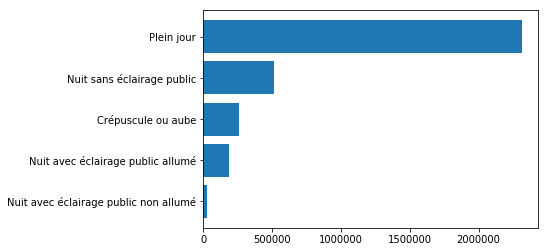

In [12]:
y = ["Plein jour", "Crépuscule ou aube", "Nuit sans éclairage public", "Nuit avec éclairage public non allumé", "Nuit avec éclairage public allumé"]
widths = []

i = 0

for dic in sinitres_luminosite_dict_format:
    dic["label"] = y[i]
    
    valeur = dic["count"]
    widths.append(valeur)
    
    i = i + 1
    
ordered_widths = sorted(widths)
ordered_labels = []

print(ordered_widths)

for width in ordered_widths:
    
    for dic in sinitres_luminosite_dict_format:
        
        if width == dic["count"]:
            print(dic)
            label = dic["label"]
            ordered_labels.append(label)

print(ordered_labels)
plt.barh(ordered_labels, ordered_widths)

## Zoom sur les accidents piétons (methode 2 : en passant par Pandas)

In [13]:
df2 = df.filter(df.catu == 3)

print("df n'a pas été modifié \ndf: ")
df.select("catu").show(10)

print("df2 ne contient que les données sur usagers piétons \ndf2: ")
df2.select("catu").show(10)

df n'a pas été modifié 
df: 
+----+
|catu|
+----+
|   1|
|   2|
|   1|
|   1|
|   1|
|   1|
|   1|
|   1|
|   1|
|   1|
+----+
only showing top 10 rows

df2 ne contient que les données sur usagers piétons 
df2: 
+----+
|catu|
+----+
|   3|
|   3|
|   3|
|   3|
|   3|
|   3|
|   3|
|   3|
|   3|
|   3|
+----+
only showing top 10 rows



In [14]:
pandas_df = df2.toPandas()
print("\nPandas DataFrame: \n", pandas_df)


Pandas DataFrame: 
              Num_Acc  catr  voie   v1    v2  circ  nbv      pr    pr1  vosp  \
0       200500002139     4   0.0  0.0  None   2.0  2.0     NaN    NaN   0.0   
1       200500002222     4   0.0  0.0  None   2.0  2.0     NaN    NaN   0.0   
2       200500003823     4   0.0  0.0  None   1.0  4.0     NaN    NaN   0.0   
3       200500003892     4   0.0  0.0  None   2.0  3.0     NaN    NaN   1.0   
4       200500004210     3   0.0  0.0  None   2.0  1.0     NaN    NaN   0.0   
5       200500004620     4   NaN  0.0  None   1.0  2.0  1009.0    0.0   0.0   
6       200500005974     4   0.0  0.0  None   1.0  1.0     NaN    NaN   0.0   
7       200500007858     4   0.0  0.0  None   2.0  3.0     NaN    NaN   0.0   
8       200500007958     6   0.0  0.0  None   0.0  0.0     NaN    NaN   0.0   
9       200500008372     4   0.0  0.0  None   4.0  3.0     1.0    0.0   0.0   
10      200500008611     4   0.0  0.0  None   2.0  2.0     NaN    NaN   0.0   
11      200500008940     4   Na

In [15]:
localisation_pieton = pandas_df["locp"].value_counts()
print(localisation_pieton)

4.0    37436
2.0    33995
3.0    25087
1.0    21738
0.0    16504
5.0     9978
6.0     3453
8.0     1388
7.0      183
Name: locp, dtype: int64


In [16]:
# Tri des des valeurs et affectation à leur labels respectifs
localisation_pieton.rename(inplace=True, index={1:"A + 50 m du passage pieton", 2: "A – 50 m du passage pieton", 3: "Sur passage pieton sans signalisation lumineuse", 4 : "Sur passage pieton (avec signalisation lumineuse)", 5 : "Sur trottoir", 6 : "Sur accotement", 7 : "Sur refuge ou BAU", 8 : "Sur contre allee", 0:"Autre"})
loc_pieton = localisation_pieton.sort_values()

In [17]:
print(loc_pieton)

Sur refuge ou BAU                                      183
Sur contre allee                                      1388
Sur accotement                                        3453
Sur trottoir                                          9978
Autre                                                16504
A + 50 m du passage pieton                           21738
Sur passage pieton sans signalisation lumineuse      25087
A – 50 m du passage pieton                           33995
Sur passage pieton (avec signalisation lumineuse)    37436
Name: locp, dtype: int64


([<matplotlib.axis.YTick at 0x7f5d040bb400>,
 <a list of 9 Text yticklabel objects>)

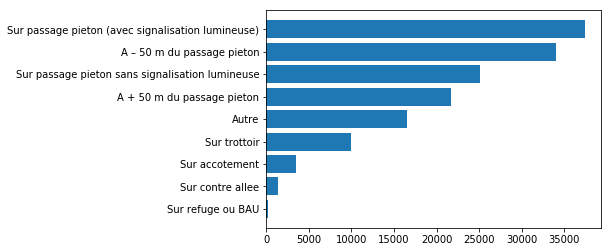

In [18]:
plt.barh(range(len(loc_pieton.index)), list(map(float, loc_pieton)))
plt.yticks(range(len(loc_pieton.index)), loc_pieton.index)

## Étude de la largeur de la route (variable continue)

In [19]:
# Min = 0 (cela veut dire que zero est la valeur par défaut quand il n'y a pas d'information. La moyenne n'a donc pas de sens. Il faut regarder la médiane)
df.agg(F.max(df.larrout), F.avg(df.larrout), F.min(df.larrout)).collect()

[Row(max(larrout)=999, avg(larrout)=63.69590090927777, min(larrout)=-81)]

In [20]:
# On calcule la médiane
df.approxQuantile("larrout", [0.5], 0)

[61.0]

In [21]:
# Combien de routes ont des largeur à zéro ?

total_rows = df.count()
no_route_total_rows = df.filter(df.larrout == 0).count()
rapport = round((no_route_total_rows / total_rows)*100, 2)
print("il y a {} % de routes qui ont une largeur égale à zéro d'après cette base de donnée. On peut supposer qu'il s'agit de la valeur par défaut quand il n'y a pas d'information".format(rapport))

il y a 28.03 % de routes qui ont une largeur égale à zéro d'après cette base de donnée. On peut supposer qu'il s'agit de la valeur par défaut quand il n'y a pas d'information


In [22]:
max_larrout_cm = df.agg({"larrout": "max"}).collect()[0][0]
max_larrout_m = max_larrout_cm/100
print("La largeur de route maximale est de {} cm soit {} m".format(max_larrout_cm, max_larrout_m))

La largeur de route maximale est de 999 cm soit 9.99 m


## Localisation des accidents

In [23]:
%%capture
#On définit une fonction qui va nous permettre d'afficher la carte de France et d'y ajouter des points
def carte_france():
    fig, axes = plt.subplots(1, 1, figsize=(15,15))

    m = Basemap(llcrnrlon=-5,llcrnrlat=40,urcrnrlon=10,urcrnrlat=52,
                resolution='i',projection='cass',lon_0=2.34,lat_0=48,
               ax=axes)
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color='grey', lake_color='#FFFFFF')

    m.drawparallels(numpy.arange(-40,61.,2.))
    m.drawmeridians(numpy.arange(-20.,21.,2.))
    m.drawmapboundary(fill_color='#FFFFFF')
    return m, axes

m, ax = carte_france()

In [24]:
# On retient les accidents qui ont des coordonnées GPS non nulles pour les afficher
#On retire également les lignes qui pourraient apparaitre plusieurs fois (à cause de Num_Acc)
accident_gps = df.filter((df.lat != "0000000") & df.long.isNotNull()).dropDuplicates(['Num_Acc'])
accident_gps.select(["Num_Acc","com","adr","gps","lat","long","grav"]).show()
print('Nombre de lignes dans le dataframe :', accident_gps.count())

+------------+---+--------------------+---+-------+-------+----+
|     Num_Acc|com|                 adr|gps|    lat|   long|grav|
+------------+---+--------------------+---+-------+-------+----+
|200500000700|246|                null|  M|4310800|0083300|   4|
|200500001181|258|                null|  M|4864800|0357400|   4|
|200500001363| 66|                null|  M|4387300|0491500|   4|
|200500010575|253|                null|  M|4959000|0214000|   4|
|200500010716|578|                null|  M|4933300|0024400|   1|
|200500011508|  4|                null|  M|4354800|0473200|   3|
|200500011600| 39|                null|  M|4345400|0364600|   1|
|200500011664| 20|                null|  M|4890200|0172200|   1|
|200500012125|318|                null|  M|5000300|0210200|   1|
|200500012201|377|                null|  M|4951900|0114100|   4|
|200500012433|273|  Chemin de la Roche|  M|4710300|-118600|   3|
|200500012706|110|                null|  M|4593000|0104300|   1|
|200500013374| 84|       

In [25]:
#On crée une fonction qui va transformer les positions GPS en position sur notre carte
schema = StructType([
    StructField("x", FloatType(), False),
    StructField("y", FloatType(), False)
])

def gps_to_position(lat, long):
    new_lat = int(lat)/100000
    new_long = int(long)/100000
    x,y = m(new_long,new_lat)
    return [x, y]

udf_gps_to_position = udf(gps_to_position, schema)

In [26]:
draw_accidents = accident_gps.select('Num_Acc', 
                                     'lat',
                                     'long', 
                                     udf_gps_to_position('lat','long').alias('position'), 
                                     'grav')
draw_accidents.show()

+------------+-------+-------+--------------------+----+
|     Num_Acc|    lat|   long|            position|grav|
+------------+-------+-------+--------------------+----+
|200500000700|4310800|0083300|[502182.5, 320862.2]|   4|
|200500001181|4864800|0357400|[715165.06, 93651...|   4|
|200500001363|4387300|0491500|[830886.94, 40804...|   4|
|200500010575|4959000|0214000|[610097.25, 10405...|   4|
|200500010716|4933300|0024400|[472654.03, 10140...|   1|
|200500011508|4354800|0473200|[817267.4, 371461...|   3|
|200500011600|4345400|0364600|[729928.8, 359062.4]|   1|
|200500011664|4890200|0172200|[579342.2, 964209...|   1|
|200500012125|5000300|0210200|[607503.8, 108647...|   1|
|200500012201|4951900|0114100|[537964.9, 103332...|   4|
|200500012433|4710300|-118600|[357726.84, 77000...|   3|
|200500012706|4593000|0104300|[524208.0, 634370.3]|   1|
|200500013374|4456000|0621000|[931011.7, 488488.8]|   4|
|200500013552|4899900|0169700|[577606.2, 975010...|   1|
|200500013585|4910300|0255000|[

In [27]:
#Les nouveaux types de la colonnes position sont bien ceux qu'on a proposé dans l'udf
draw_accidents.dtypes

[('Num_Acc', 'bigint'),
 ('lat', 'string'),
 ('long', 'string'),
 ('position', 'struct<x:float,y:float>'),
 ('grav', 'int')]

In [28]:
#pour des soucis de performances on ne garde que les 100 premières lignes du dataframe 
list_accidents_positions = draw_accidents.take(100)
list_accidents_positions

[Row(Num_Acc=200500000700, lat='4310800', long='0083300', position=Row(x=502182.5, y=320862.1875), grav=4),
 Row(Num_Acc=200500001181, lat='4864800', long='0357400', position=Row(x=715165.0625, y=936515.0625), grav=4),
 Row(Num_Acc=200500001363, lat='4387300', long='0491500', position=Row(x=830886.9375, y=408042.34375), grav=4),
 Row(Num_Acc=200500010575, lat='4959000', long='0214000', position=Row(x=610097.25, y=1040546.9375), grav=4),
 Row(Num_Acc=200500010716, lat='4933300', long='0024400', position=Row(x=472654.03125, y=1014058.1875), grav=1),
 Row(Num_Acc=200500011508, lat='4354800', long='0473200', position=Row(x=817267.375, y=371461.65625), grav=3),
 Row(Num_Acc=200500011600, lat='4345400', long='0364600', position=Row(x=729928.8125, y=359062.40625), grav=1),
 Row(Num_Acc=200500011664, lat='4890200', long='0172200', position=Row(x=579342.1875, y=964209.25), grav=1),
 Row(Num_Acc=200500012125, lat='5000300', long='0210200', position=Row(x=607503.8125, y=1086478.25), grav=1),
 Row

/opt/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/opt/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


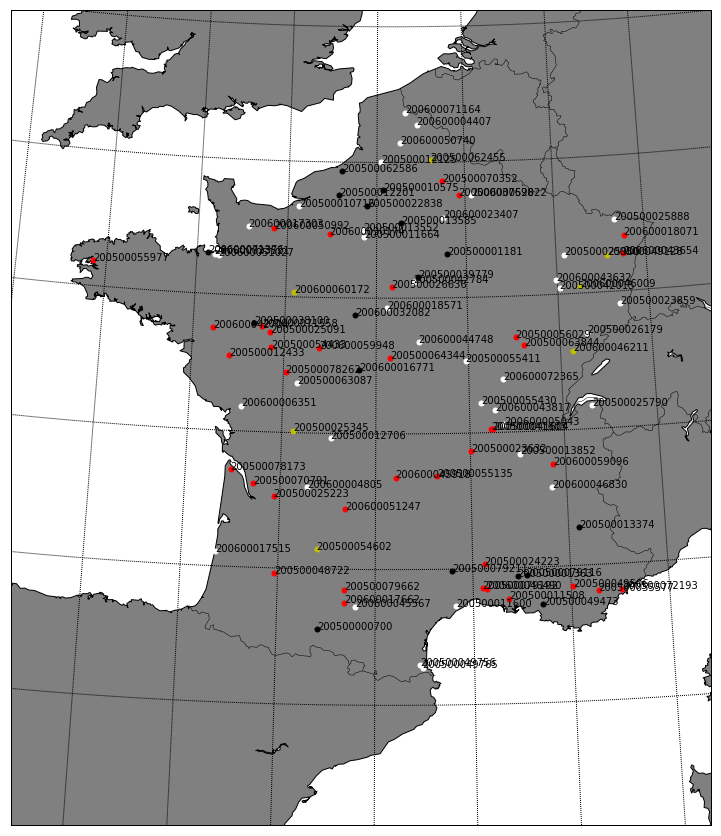

In [29]:
#On affiche les résultats
m, ax = carte_france()
colors = [
    '', 
    'wo', #blanc : indemne
    'yo', #jaune : bléssure(s) légère(s)
    'ro', #rouge : hospitalisation
    'ko' #noir : mort
]

for element in list_accidents_positions:
    m.plot(element['position']['x'], element['position']['y'], colors[element['grav']], markersize=5)
    ax.text(element['position']['x'], element['position']['y'], element['Num_Acc'])

## Étude de la corrélation entre Météo et État de la surface et moi de l'année

In [30]:
# Les variables sont ici catégorielles, effectuons un test du chi²
# Il faut pour cela que la colonne surf soit au format vecteur

pip = []
assembler_features = VectorAssembler(inputCols=["surf"], outputCol='surf_vect')
pip+= [assembler_features]

myPipeline= Pipeline(stages=pip)
df_in = df.filter(df.surf.isNotNull())
df_out = myPipeline.fit(df_in).transform(df_in)

r = ChiSquareTest.test(df_out, "surf_vect", "atm").head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))

pValues: [0.0]
degreesOfFreedom: [81]
statistics: [3897366.4390521045]


On constate que les résultats sont aberrants. En testant la corrélation entre d'autres colonnes, on obtient la même pValues... Sans doute une mauvaise utilisation de la fonction!

# III.  Prédictions (Pipelines)

## III.1 Préparation des données

In [31]:
pip_preparation = []
features_a_assembler = []

### III.1.1 À la recherche de null

In [32]:
col_null = []

for col in df.columns:
    filtered_df = df.filter(df[col].isNull())
    nb_null = filtered_df.count()
    
    if nb_null > 0:
        col_null.append((col, nb_null, nb_null/df.count()))

In [33]:
count = 0
elem_a_dropper = []
elem_a_filtrer = []

for elem in col_null:
    
    if elem[2] > 0.05:
        elem_a_dropper.append(elem[0])
        print("Au dessus du seuil : ", elem[0], elem[2])
        count += 1
    
    else:
        elem_a_filtrer.append(elem[0])

print("\nelem_a_dropper : \n", elem_a_dropper)
print("\nelem_a_filtrer : \n", elem_a_filtrer)
print("\nOn va dropper ces colonnes car elles ont beaucoup de valeurs manquantes et par ailleurs elles n'ont pas l'air d'être des colonnes importantes pour la prédiction de la gravité de l'accident")

Au dessus du seuil :  voie 0.052929756816685825
Au dessus du seuil :  v1 0.5684556327710522
Au dessus du seuil :  v2 0.9544527996262918
Au dessus du seuil :  pr 0.4580727942269367
Au dessus du seuil :  pr1 0.459647100576639
Au dessus du seuil :  adr 0.18762395008326532
Au dessus du seuil :  gps 0.5763732713721945
Au dessus du seuil :  lat 0.5808662628272601
Au dessus du seuil :  long 0.5808741495257365

elem_a_dropper : 
 ['voie', 'v1', 'v2', 'pr', 'pr1', 'adr', 'gps', 'lat', 'long']

elem_a_filtrer : 
 ['catr', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'lartpc', 'larrout', 'surf', 'infra', 'situ', 'env1', 'atm', 'col', 'com', 'dep', 'place', 'trajet', 'secu', 'locp', 'actp', 'etatp', 'an_nais', 'obs', 'obsm', 'choc', 'manv', 'age']

On va dropper ces colonnes car elles ont beaucoup de valeurs manquantes et par ailleurs elles n'ont pas l'air d'être des colonnes importantes pour la prédiction de la gravité de l'accident


In [34]:
elem_a_dropper = ["voie", "v1", "v2", "pr", "pr1", "adr", "gps", "lat", "long"]

# Suppression des colonnes possèdant trop de null
for elem in elem_a_dropper:
    df = df.drop(elem)

In [35]:
# Verification que les colonnes ont bien été supprimé
for elem in elem_a_dropper:
    
    if elem in df.columns:
        print("La colonne {} n'a pas été supprimée !".format(elem))
    
    else:
        print(elem, "a bien été supprimé !")
    
all_col = set(df.columns)

voie a bien été supprimé !
v1 a bien été supprimé !
v2 a bien été supprimé !
pr a bien été supprimé !
pr1 a bien été supprimé !
adr a bien été supprimé !
gps a bien été supprimé !
lat a bien été supprimé !
long a bien été supprimé !


In [36]:
# filtrage des lignes contenant des null

elem_a_filtrer = ['catr', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'lartpc', 'larrout', 'surf', 'infra', 'situ', 'env1', 'atm', 'col', 'com', 'dep', 'place', 'trajet', 'secu', 'locp', 'actp', 'etatp', 'an_nais', 'obs', 'obsm', 'choc', 'manv', 'age']
for elem in elem_a_filtrer:
    df = df.filter(df[elem].isNotNull())

### III.1.2 StandardScaler

In [38]:
#  Lister les variables numériques

print("Variables numériques potentielles (avec suffisament de valeurs distinctes) : \n")

for col in df.columns:
    denombrement = df.select([col]).distinct().count()
    
    if denombrement > 100:
        print(col, denombrement)

print("\nParmi ces variables on voit que les variables suivantes ne peuvent pas être numériques : les communes (com), les départements (dep), les années de naissance (an_nais), ainsi que les numéros de voies (voie)")
print("\nParmi ces variables on va supprimer les variables Num_Acc (car inutile pour la prédiction) et an_nais (car un peu redondant avec age mais moins predictif)")
print("\nD'autre part il faut convertir les heures-minutes en heures pour que les chiffres aient du sens en variables numériques.")

Variables numériques potentielles (avec suffisament de valeurs distinctes) : 

Num_Acc 764245
lartpc 364
larrout 531
hrmn 1439
com 922
dep 122
an_nais 120
num_veh 113
occutc 114
age 110

Parmi ces variables on voit que les variables suivantes ne peuvent pas être numériques : les communes (com), les départements (dep), les années de naissance (an_nais), ainsi que les numéros de voies (voie)

Parmi ces variables on va supprimer les variables Num_Acc (car inutile pour la prédiction) et an_nais (car un peu redondant avec age mais moins predictif)

D'autre part il faut convertir les heures-minutes en heures pour que les chiffres aient du sens en variables numériques.


In [39]:
df.select("hrmn").show()

+----+
|hrmn|
+----+
|1730|
|1730|
|1930|
|1930|
|1930|
|1930|
|1930|
|1930|
|1930|
|1930|
|1930|
|1930|
|1930|
|1930|
|1930|
|1930|
| 715|
| 715|
| 715|
| 715|
+----+
only showing top 20 rows



In [40]:
def hrmin_to_heures(x):
    x_str = str(x)
    print(x_str)
    l = len(x_str)
    
    if l == 4:
        
        heures_str = x_str[:2]
        minutes_str = x_str[2:]
        
        heures = float(heures_str)
        minutes = float(minutes_str)/60
        
        return(heures + minutes)
    
    elif l == 3:
        heures_str = x_str[:1]
        minutes_str = x_str[1:]
        
        heures = float(heures_str)
        minutes = float(minutes_str)/60
        
        return(heures + minutes)
    
    elif (l < 3 and l > 0):

        minutes_str = x_str
        
        heures = 0
        minutes = float(minutes_str)/60
        
        return(heures + minutes)
        
    else:
        print("Pas le bon format")

udf_hrmin_to_heures = udf(hrmin_to_heures, FloatType())

df = df.withColumn("heure", udf_hrmin_to_heures(df.hrmn))

df.select(["hrmn", "heure"]).show()

+----+-----+
|hrmn|heure|
+----+-----+
|1730| 17.5|
|1730| 17.5|
|1930| 19.5|
|1930| 19.5|
|1930| 19.5|
|1930| 19.5|
|1930| 19.5|
|1930| 19.5|
|1930| 19.5|
|1930| 19.5|
|1930| 19.5|
|1930| 19.5|
|1930| 19.5|
|1930| 19.5|
|1930| 19.5|
|1930| 19.5|
| 715| 7.25|
| 715| 7.25|
| 715| 7.25|
| 715| 7.25|
+----+-----+
only showing top 20 rows



In [41]:
# Il faut que les variables à standard scaler soient mises au bon format
elem_a_std_scaler = ["lartpc", "larrout", "occutc", "age", "heure"]
num_var = ["hrmn"]

variables_a_StandardScaler = []

for elem in elem_a_std_scaler:
    
    assembler_features = VectorAssembler(inputCols=[elem], outputCol='{}_prevect'.format(elem))
    pip_preparation += [assembler_features]
    variables_a_StandardScaler.append('{}_prevect'.format(elem))
    num_var.append(elem)
    num_var.append('{}_prevect'.format(elem))

In [42]:
drop_other = ["an_nais", "Num_Acc"]

for elem in drop_other:
    df = df.drop(elem)

In [43]:
for var in variables_a_StandardScaler:
    var_scaled = '{}_scaled'.format(var)
    features_a_assembler.append(var_scaled)
    pip_preparation += [StandardScaler(inputCol=var, outputCol=var_scaled)]
    

### III.1.3 StringIndexer

In [44]:
variables_a_string_indexer = []

for type_elem in df.dtypes:
    if type_elem[0] == "num_veh":
        print(type_elem[1])
        
    if type_elem[1] == "string":
        variables_a_string_indexer.append(type_elem[0])


print("Il y a {} éléments à StringIndexer il s'agit de {}. Cette variable ne sera prédictive ... On peut directement supprimer cette colonne".format(len(variables_a_string_indexer), variables_a_string_indexer[0]))

df = df.drop("num_veh")

string
Il y a 1 éléments à StringIndexer il s'agit de num_veh. Cette variable ne sera prédictive ... On peut directement supprimer cette colonne


### III.1.4 OneHotEncoder

In [45]:
all_col = set(df.columns)
negative_col = []

for col in all_col:
    print(col)
    filtered_df = df.filter(df[col] < 0)
    nb_neg = filtered_df.count()
    
    if nb_neg > 0:
        print(col, ": colonne suspecte")
        df = df.filter(df[col] > 0)

catv
grav
atm
mois
actp
an
dep
dep : colonne suspecte
int
larrout
larrout : colonne suspecte
infra
trajet
senc
locp
etatp
place
surf
secu
choc
lum
jour
heure
env1
age
agg
manv
plan
hrmn
situ
com
obsm
vosp
prof
occutc
year
sexe
catr
circ
lartpc
nbv
col
obs
catu


In [46]:
num_var.append('hrmn')
all_col = set(df.columns)
a_enlever = set(["nbv", "jour", "an", "com", "dep", "catv"])
numerical_col = set(num_var)
target_col = set(["grav"])

print(all_col)
print(numerical_col)

colonnes_a_OneHotEncoder = all_col - numerical_col - a_enlever - target_col

print(colonnes_a_OneHotEncoder)

for var in colonnes_a_OneHotEncoder:
    var_scaled = '{}_vect'.format(var)
    features_a_assembler.append(var_scaled)
    pip_preparation += [OneHotEncoder(inputCol=var, outputCol=var_scaled)]

{'catv', 'grav', 'atm', 'mois', 'actp', 'an', 'dep', 'int', 'larrout', 'infra', 'trajet', 'senc', 'locp', 'etatp', 'place', 'surf', 'secu', 'choc', 'lum', 'jour', 'heure', 'env1', 'age', 'agg', 'manv', 'plan', 'hrmn', 'situ', 'com', 'obsm', 'vosp', 'prof', 'occutc', 'year', 'sexe', 'catr', 'circ', 'lartpc', 'nbv', 'col', 'obs', 'catu'}
{'larrout', 'occutc', 'heure', 'age_prevect', 'age', 'lartpc_prevect', 'lartpc', 'larrout_prevect', 'hrmn', 'occutc_prevect', 'heure_prevect'}
{'lum', 'env1', 'atm', 'agg', 'manv', 'plan', 'mois', 'actp', 'situ', 'obsm', 'vosp', 'int', 'prof', 'infra', 'trajet', 'year', 'sexe', 'catr', 'senc', 'circ', 'locp', 'etatp', 'col', 'place', 'surf', 'secu', 'obs', 'catu', 'choc'}


In [47]:
for col in colonnes_a_OneHotEncoder:
    
    nb = df.select([col]).distinct().count()
    if nb > 10:
        print(col)

manv
mois
year
secu
obs


### III.1.5 VectorAssembler

In [48]:
features_a_assembler

['lartpc_prevect_scaled',
 'larrout_prevect_scaled',
 'occutc_prevect_scaled',
 'age_prevect_scaled',
 'heure_prevect_scaled',
 'lum_vect',
 'env1_vect',
 'atm_vect',
 'agg_vect',
 'manv_vect',
 'plan_vect',
 'mois_vect',
 'actp_vect',
 'situ_vect',
 'obsm_vect',
 'vosp_vect',
 'int_vect',
 'prof_vect',
 'infra_vect',
 'trajet_vect',
 'year_vect',
 'sexe_vect',
 'catr_vect',
 'senc_vect',
 'circ_vect',
 'locp_vect',
 'etatp_vect',
 'col_vect',
 'place_vect',
 'surf_vect',
 'secu_vect',
 'obs_vect',
 'catu_vect',
 'choc_vect']

In [49]:
assembler_features = VectorAssembler(inputCols=features_a_assembler, outputCol='features')
pip_preparation += [assembler_features]

In [50]:
pip_preparation

[VectorAssembler_4deeb350796ca79887f8,
 VectorAssembler_4ef8b3d594a4712ea082,
 VectorAssembler_4cea8cbdd6364acaca6e,
 VectorAssembler_41b3957c3f67daf9e454,
 VectorAssembler_4e8898e2478b2cfa3663,
 StandardScaler_45c5980cedf060647472,
 StandardScaler_48bdbaf53bdd4d734d60,
 StandardScaler_406ebab0b910f80682ad,
 StandardScaler_42aba8f7ae8bc09725a4,
 StandardScaler_4042b575bc3f765637b1,
 OneHotEncoder_46ccaee999d0a9e93c87,
 OneHotEncoder_4fccb2bf2ba859cb1357,
 OneHotEncoder_4498877ef1b1598b052b,
 OneHotEncoder_4e06a58353cdf6d342d1,
 OneHotEncoder_42d58ccfa01276a1b5d1,
 OneHotEncoder_42d1b10ac4a6b8f64c7a,
 OneHotEncoder_45139aee9d3f5ecf34e3,
 OneHotEncoder_4fab92e07d2531b59560,
 OneHotEncoder_4703826ffb0eb0b07efb,
 OneHotEncoder_4cd381dd8ffa3a4aadb7,
 OneHotEncoder_41e7ad6b2209c52de193,
 OneHotEncoder_4e2087df149a993b7cc0,
 OneHotEncoder_47578efb918fb10fcdfa,
 OneHotEncoder_486ebfd2bd7f4ca96bb5,
 OneHotEncoder_45aab44e2521c451a4fc,
 OneHotEncoder_45a38627fd744b199396,
 OneHotEncoder_4ec8868b

In [51]:
myPipeline= Pipeline(stages=pip_preparation)

df_out = myPipeline.fit(df).transform(df)

In [52]:
df_out.dtypes

[('catr', 'int'),
 ('circ', 'int'),
 ('nbv', 'int'),
 ('vosp', 'int'),
 ('prof', 'int'),
 ('plan', 'int'),
 ('lartpc', 'int'),
 ('larrout', 'int'),
 ('surf', 'int'),
 ('infra', 'int'),
 ('situ', 'int'),
 ('env1', 'int'),
 ('year', 'int'),
 ('an', 'int'),
 ('mois', 'int'),
 ('jour', 'int'),
 ('hrmn', 'int'),
 ('lum', 'int'),
 ('agg', 'int'),
 ('int', 'int'),
 ('atm', 'int'),
 ('col', 'int'),
 ('com', 'int'),
 ('dep', 'int'),
 ('place', 'int'),
 ('catu', 'int'),
 ('grav', 'int'),
 ('sexe', 'int'),
 ('trajet', 'int'),
 ('secu', 'int'),
 ('locp', 'int'),
 ('actp', 'int'),
 ('etatp', 'int'),
 ('senc', 'int'),
 ('catv', 'int'),
 ('occutc', 'int'),
 ('obs', 'int'),
 ('obsm', 'int'),
 ('choc', 'int'),
 ('manv', 'int'),
 ('age', 'int'),
 ('heure', 'float'),
 ('lartpc_prevect', 'vector'),
 ('larrout_prevect', 'vector'),
 ('occutc_prevect', 'vector'),
 ('age_prevect', 'vector'),
 ('heure_prevect', 'vector'),
 ('lartpc_prevect_scaled', 'vector'),
 ('larrout_prevect_scaled', 'vector'),
 ('occutc_pr

### III.1.6 Classification Binaire -> binarisation de la colonne 'grav'

In [53]:
#On transforme la colonne 'grav'
#1 : accident entrainant la mort
#0 : autres
def grav_binaire(gravite):
    if gravite == 2:
        return 1.0
    else:
        return 0.0
udf_grav_binaire = udf(grav_binaire, DoubleType())

In [54]:
df_out_final = df_out.select("features", udf_grav_binaire("grav").alias('grav_binaire'))
df_out_final.show()

+--------------------+------------+
|            features|grav_binaire|
+--------------------+------------+
|(2405,[1,3,4,6,10...|         0.0|
|(2405,[1,3,4,6,10...|         0.0|
|(2405,[0,1,3,4,8,...|         0.0|
|(2405,[0,1,3,4,8,...|         0.0|
|(2405,[0,1,3,4,8,...|         0.0|
|(2405,[0,1,3,4,8,...|         0.0|
|(2405,[0,1,3,4,8,...|         0.0|
|(2405,[0,1,3,4,8,...|         0.0|
|(2405,[0,1,3,4,8,...|         0.0|
|(2405,[0,1,3,4,8,...|         0.0|
|(2405,[0,1,3,4,8,...|         0.0|
|(2405,[0,1,3,4,8,...|         0.0|
|(2405,[1,3,4,7,10...|         0.0|
|(2405,[1,3,4,7,10...|         0.0|
|(2405,[1,3,4,7,10...|         0.0|
|(2405,[1,3,4,7,10...|         0.0|
|(2405,[1,3,4,8,10...|         0.0|
|(2405,[1,3,4,8,10...|         0.0|
|(2405,[1,3,4,8,10...|         0.0|
|(2405,[1,3,4,8,10...|         0.0|
+--------------------+------------+
only showing top 20 rows



In [55]:
nb_morts = df_out_final.filter(df_out_final.grav_binaire > 0).count()
nb_individus = df_out_final.count()
print("Nombre de morts sur le nombre total d'individu impliqué dans des accidents :",
      nb_morts,
      "/",
      nb_individus,
      "(" + str((nb_morts/nb_individus)*100) + "%)"
     )

Nombre de morts sur le nombre total d'individu impliqué dans des accidents : 60043 / 2274697 (2.639604307738569%)


Le dataset est très déséquilibré. Nos résultats risquent d'être très mauvais.

On 'undersample' l'échantillon le plus représenté

In [56]:
stratified_df = df_out_final.sampleBy("grav_binaire", fractions={0: 0.1, 1: 1}, seed=0)

In [57]:
nb_morts = stratified_df.filter(stratified_df.grav_binaire > 0).count()
nb_individus = stratified_df.count()
print("Nombre de morts sur le nombre total d'individu impliqué dans des accidents :",
      nb_morts,
      "/",
      nb_individus,
      "(" + str((nb_morts/nb_individus)*100) + "%)"
     )

Nombre de morts sur le nombre total d'individu impliqué dans des accidents : 60043 / 282161 (21.279694925946536%)


## III.2 Model 1 : Regression Logistique

In [58]:
#train/test split 
train, test = stratified_df.randomSplit([0.7, 0.3], seed = 12345)
logreg = LogisticRegression(labelCol="grav_binaire", 
                            featuresCol="features", 
                            maxIter=10,
                            regParam=0.01,        # L2 regularization
                            elasticNetParam=0.01) # L1 regularization

In [59]:
%%time
logreg_model = logreg.fit(train)

CPU times: user 260 ms, sys: 113 ms, total: 373 ms
Wall time: 59.5 s


In [60]:
%%time
pred_test = logreg_model.transform(test)

CPU times: user 1.94 ms, sys: 8.93 ms, total: 10.9 ms
Wall time: 62.1 ms


In [61]:
pred_test.show(100)

+--------------------+------------+--------------------+--------------------+----------+
|            features|grav_binaire|       rawPrediction|         probability|prediction|
+--------------------+------------+--------------------+--------------------+----------+
|(2405,[0,1,3,4,6,...|         0.0|[1.76466685199173...|[0.85379318751147...|       0.0|
|(2405,[0,1,3,4,6,...|         0.0|[1.76456720213083...|[0.85378074774286...|       0.0|
|(2405,[0,1,3,4,6,...|         0.0|[1.27077817494524...|[0.78087592952775...|       0.0|
|(2405,[0,1,3,4,6,...|         0.0|[2.45964459139332...|[0.92126388650802...|       0.0|
|(2405,[0,1,3,4,6,...|         0.0|[1.27406854890730...|[0.78143842082455...|       0.0|
|(2405,[0,1,3,4,6,...|         0.0|[1.29562764333101...|[0.78509820294131...|       0.0|
|(2405,[0,1,3,4,6,...|         0.0|[1.63133756428005...|[0.83635278929188...|       0.0|
|(2405,[0,1,3,4,6,...|         0.0|[3.62080174647347...|[0.97393628444050...|       0.0|
|(2405,[0,1,3,4,6,...

In [62]:
pred_test.dtypes

[('features', 'vector'),
 ('grav_binaire', 'double'),
 ('rawPrediction', 'vector'),
 ('probability', 'vector'),
 ('prediction', 'double')]

In [63]:
# On évalue la précision du modèle
evaluator = MulticlassClassificationEvaluator(
    labelCol="grav_binaire", predictionCol="prediction", metricName="accuracy")

accuracy_lr = evaluator.evaluate(pred_test)
print("Test Error Logistic Regression = %g " % (1.0 - accuracy_lr))

Test Error Logistic Regression = 0.169608 


## III.3 Model 2 : Random Forest

In [64]:
rf = RandomForestClassifier(labelCol="grav_binaire", 
                            featuresCol="features", 
                            numTrees=10, 
                            maxDepth=1
                           )

In [65]:
%%time
rf_model = rf.fit(train)

CPU times: user 95.2 ms, sys: 32.1 ms, total: 127 ms
Wall time: 2min 42s


In [66]:
%%time
rf_predictions = rf_model.transform(test)

CPU times: user 15.5 ms, sys: 0 ns, total: 15.5 ms
Wall time: 47.3 ms


In [68]:
accuracy_rf = evaluator.evaluate(rf_predictions)
print("Test Error Random Forest = %g " % (1.0 - accuracy_rf))

Test Error Random Forest = 0.210652 


Les paramètres que nous avons mis sur les 2 modèles sacrifient leur précision pour préférer la rapidité.  
On constate qu'ils font à peine mieux que le prédicteur le plus plus simple qui consiste à dire que toutes les victimes sont en vie.